In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import IPython.display as ipd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
import os

## Data imporation and processing

In [2]:
#directory to training data and json file
train_dir='D:/nsynth_train/nsynth_train_data/nsynth-train/examples.json'
df_train= pd.read_json(train_dir, orient='index')
df_train.head(5)

,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities,qualities_str,sample_rate,velocity
guitar_acoustic_001-082-050,39,3,guitar,0,acoustic,guitar_acoustic_001,16629,guitar_acoustic_001-082-050,82,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
bass_synthetic_120-108-050,881,0,bass,2,synthetic,bass_synthetic_120,168243,bass_synthetic_120-108-050,108,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
organ_electronic_120-050-127,979,6,organ,1,electronic,organ_electronic_120,88495,organ_electronic_120-050-127,50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,127
guitar_electronic_021-026-025,346,3,guitar,1,electronic,guitar_electronic_021,146382,guitar_electronic_021-026-025,26,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]","[fast_decay, percussive]",16000,25
organ_electronic_011-079-075,188,6,organ,1,electronic,organ_electronic_011,244275,organ_electronic_011-079-075,79,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[bright],16000,75


In [3]:
#Checking number of samples per instrument family for the note A4
instruments_diapason = df_train.loc[(df_train["pitch"]==69) & (df_train["instrument_source"]==0)]
instruments_diapason["instrument_family_str"].value_counts()

mallet      353
string      350
reed        252
brass       250
guitar      154
flute       138
vocal       110
keyboard     96
organ         2
Name: instrument_family_str, dtype: int64

In [4]:
#importing samples
sample_names = list(instruments_diapason.index)
full_sample_names = ['D:/nsynth_train/nsynth_train_data/nsynth-train/audio/'+i+'.wav' for i in sample_names]
instruments_diapason["sample"] = [librosa.load(i, sr=None)[0] for i in full_sample_names]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
#Adding CQTs and mean CQTs
instruments_diapason["cqt"] = [np.abs(librosa.cqt(y=y_out, sr=sr_out)) for y_out,sr_out in zip(instruments_diapason["sample"],instruments_diapason["sample_rate"])]
instruments_diapason["cqt_mean"] = [np.mean(cq, axis=1) for cq in instruments_diapason["cqt"]]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#andding columns for the translation of CQT data into dB data
instruments_diapason["db"] = [librosa.amplitude_to_db(np.abs(C),ref=np.min) for C in instruments_diapason["cqt"]]
instruments_diapason["db_mean"] = [np.mean(cq, axis=1) for cq in instruments_diapason["db"]]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Data exploration

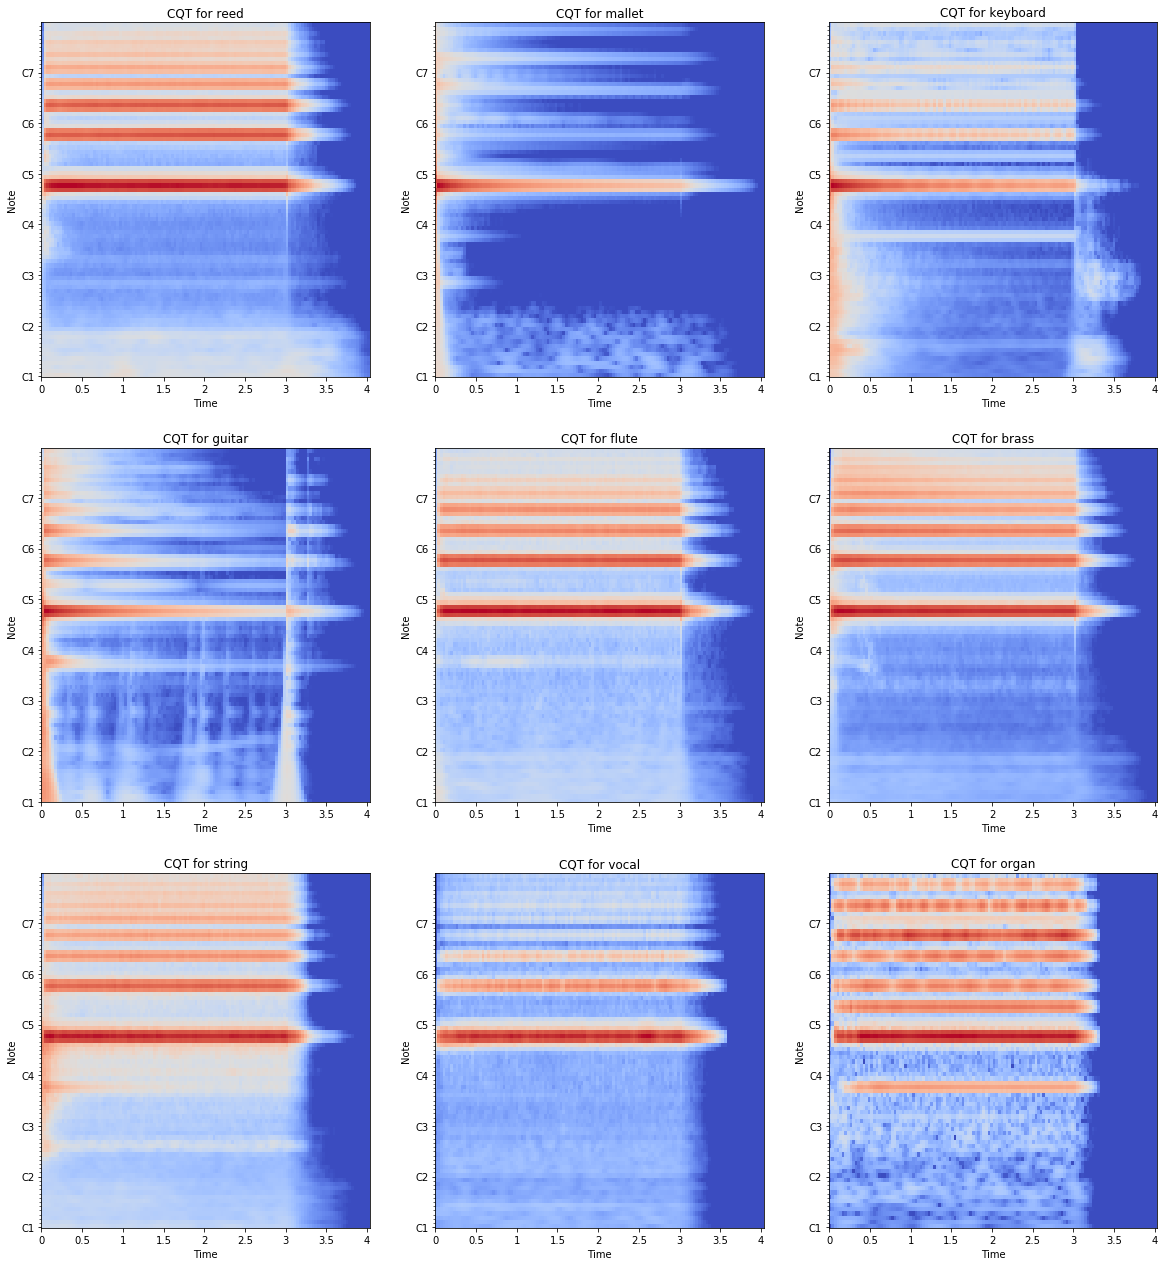

In [7]:
#displaying mean CQT per instrument family
sr_out = 16000
instrument_names = instruments_diapason["instrument_family_str"].unique()
k = 1
plt.figure(figsize=(20,30))
for i in instrument_names:
    plt.subplot(4,3,k)
    plt.title("CQT for "+i)
    mean_cqt_instrument = np.mean(instruments_diapason.loc[instruments_diapason["instrument_family_str"]==i]["cqt"])
    mean_log_cqt = librosa.amplitude_to_db(np.abs(mean_cqt_instrument),ref=np.min)
    librosa.display.specshow(mean_log_cqt, sr=sr_out, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    #plt.colorbar(format='%+2.0f dB')
    k=k+1

In [8]:
#Making a dataset with mean CQT values only
test_sample_diapason = pd.DataFrame(instruments_diapason["cqt_mean"].values.tolist(),index=instruments_diapason.index)
test_sample_diapason.head(5)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
reed_acoustic_024-069-025,0.108335,0.100039,0.065184,0.056328,0.051050,0.047950,0.036621,0.039088,0.038351,0.035375,...,0.020589,0.022347,0.051870,0.031172,0.041789,0.058117,0.026209,0.028354,0.017535,0.009767
mallet_acoustic_048-069-075,0.010994,0.010968,0.010768,0.010365,0.009755,0.008894,0.007796,0.006454,0.004899,0.003155,...,0.004735,0.000756,0.000159,0.000063,0.000013,0.000020,0.000019,0.000010,0.000005,0.000014
keyboard_acoustic_017-069-075,0.000052,0.000037,0.000047,0.000078,0.000085,0.000065,0.000061,0.000065,0.000066,0.000068,...,0.001613,0.000320,0.001257,0.000291,0.000941,0.001721,0.001198,0.000590,0.000294,0.000146
reed_acoustic_041-069-050,0.023864,0.025331,0.026473,0.021181,0.017887,0.017422,0.011386,0.008786,0.010269,0.015452,...,0.023645,0.028568,0.060696,0.034116,0.011521,0.015171,0.009488,0.013800,0.009019,0.007580
reed_acoustic_056-069-050,0.036620,0.054659,0.075630,0.053486,0.051527,0.073854,0.049848,0.018571,0.016040,0.021150,...,0.008592,0.016655,0.035162,0.019644,0.013781,0.018095,0.007017,0.003218,0.003228,0.005977


In [9]:
#reordering notes to increase performance of the LSTM
notes_order = [9,4,0,2,5,7,11,10,1,3,6,8]
cols2=[]
for i in notes_order:
    for j in range(0,7):
            cols2.append(i+j*12)
test_sample_diapason = test_sample_diapason[cols2]
#9 modulo 12 #fundamental
#4 modulo 12 #fifth
#0 modulo 12 #third #erratum: should be 1
#2 modulo 12 #fourth
#5 modulo 12 #sixth #erratum: should be 6
#7 modulo 12 #seventh #erratum: should be 8
#11 modulo 12 #second
#10 modulo 12 #fundamental#
#1 modulo 12 #thirdb #erratum: should be 0
#3 modulo 12 #fourthb
#6 modulo 12 #sixthb #erratum: should be 5
#8 modulo 12 #seventhb #erratum: should be 7

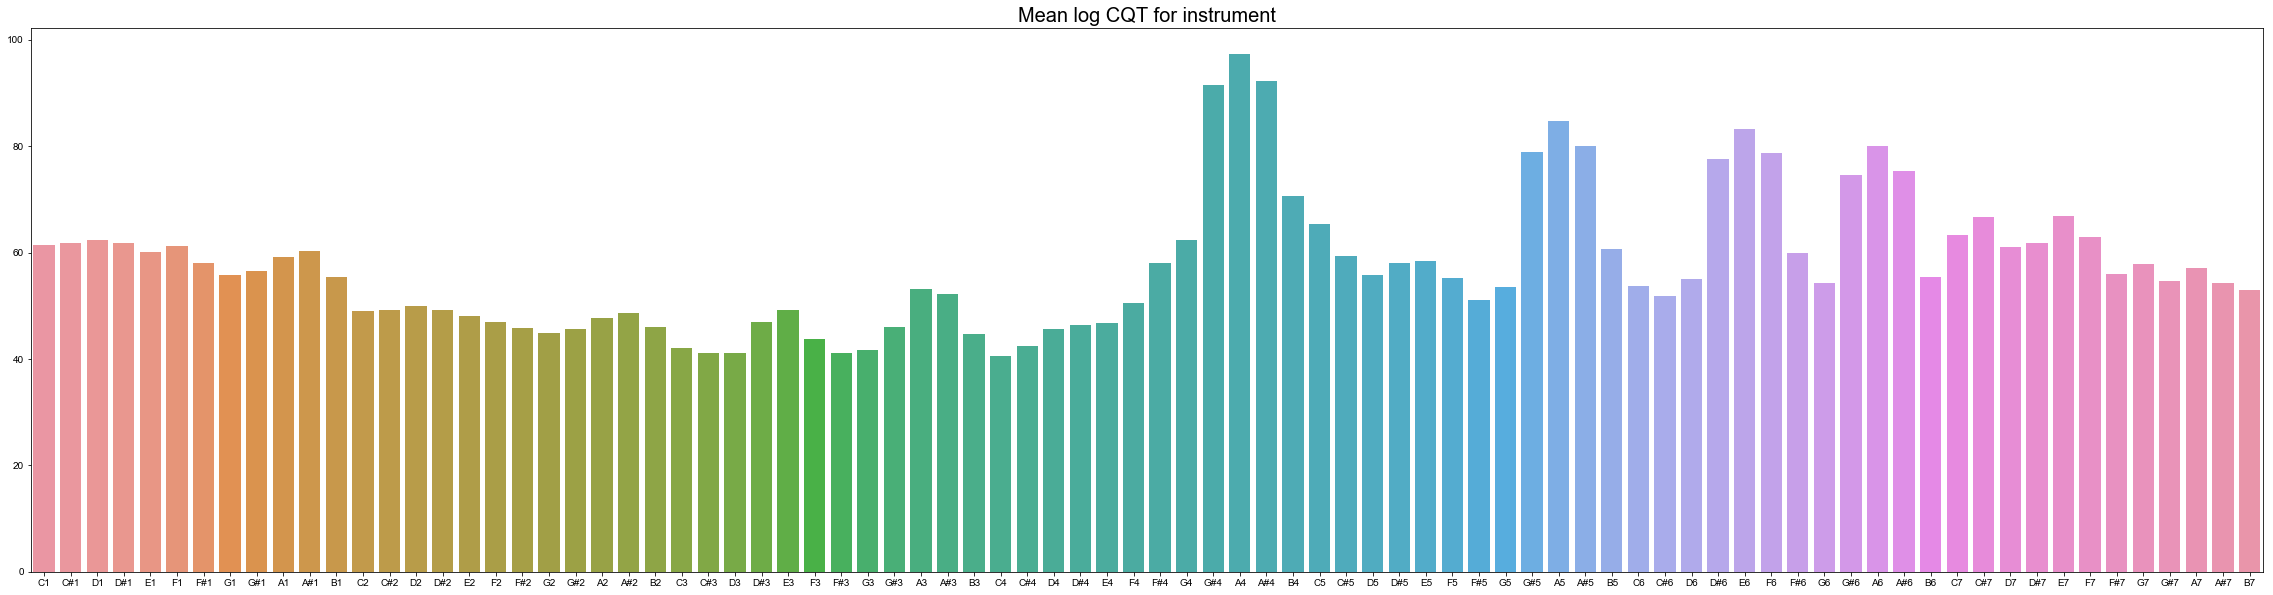

In [10]:
#example of instrument mean CQT
octaves = []
for i in range(1,8):
    octaves= octaves+['C'+str(i),'C#'+str(i),'D'+str(i),'D#'+str(i),'E'+str(i),'F'+str(i),'F#'+str(i),'G'+str(i),'G#'+str(i),'A'+str(i),'A#'+str(i),'B'+str(i)]
logC_mean = instruments_diapason.iloc[3]["db_mean"]

#plt.figure(figsize=(10,30))
plt.figure(figsize=(40,10))
plt.title("Mean log CQT for instrument", size= 20)
sns.set(font_scale = 1.7)
sns.set_style("white")
#sns.barplot(x=logC_mean, y=octaves)
sns.barplot(y=logC_mean, x=octaves)

In [11]:
#defining a local optima function to retrieve all local optima in mean CQT except octaves of the main frequency
def local_optima(indexed_row):
    a = []
    for i in range(len(indexed_row)):
        if i == 0 or i >= len(indexed_row)-1:
           1==1 
        elif (indexed_row[i][0]>indexed_row[i-1][0]) and (indexed_row[i][0]>indexed_row[i+1][0]) and (i%12 != 45%12):
            a.append(i)
        elif i == 45:
            a.append(i)
    return a

In [12]:
#defining a function to retrieve the main harmony expressed in semitones of difference with the main frequency
def main_harmony(row):
    indexed_row = [(row[i],i )for i in range(len(row))]
    filtered_row = [indexed_row[i] for i in local_optima(indexed_row)]
    ordered_row = sorted(filtered_row, key = lambda r : -r[0])
    try:
        return (ordered_row[1][1]-ordered_row[0][1])%12
    except:
        return np.nan

In [13]:
#idem with second main harmony
def second_main_harmony(row):
    indexed_row = [(row[i],i )for i in range(len(row))]
    filtered_row = [indexed_row[i] for i in local_optima(indexed_row)]
    ordered_row = sorted(filtered_row, key = lambda r : -r[0])
    try:
        return (ordered_row[2][1]-ordered_row[0][1])%12
    except:
        return np.nan

In [14]:
#computing main harmony for all the dataset
test_sample_diapason["main_harmony"]=instruments_diapason["db_mean"].apply(main_harmony)
instruments_diapason["main_harmony"]=test_sample_diapason["main_harmony"]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#idem with second main harmony
test_sample_diapason["second_main_harmony"]=instruments_diapason["db_mean"].apply(second_main_harmony)
instruments_diapason["second_main_harmony"]=test_sample_diapason["second_main_harmony"]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
#idem with entropy
test_sample_diapason["entropy"] = test_sample_diapason.apply(lambda row: entropy(row[:-2]), axis=1)
instruments_diapason["entropy"]=test_sample_diapason["entropy"]

C:\Users\Pigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
#putting contextual variables in front of each sample
cols = list(test_sample_diapason.columns)
new_cols = [cols[-1]]+[cols[-2]]+[cols[-3]]+cols[:-3]
test_sample_diapason=test_sample_diapason[new_cols]
test_sample_diapason.head(5)

,entropy,second_main_harmony,main_harmony,9,21,33,45,57,69,81,...,54,66,78,8,20,32,44,56,68,80
reed_acoustic_024-069-025,2.954621,11,7,0.035375,0.004293,0.002806,1.683714,0.782316,0.280289,0.028354,...,0.007414,0.038331,0.041789,0.038351,0.002455,0.003137,0.790524,0.349385,0.125873,0.026209
mallet_acoustic_048-069-075,3.293562,11,4,0.003155,0.004921,0.006263,0.155817,0.001636,0.000018,0.000010,...,0.002185,0.000354,0.000013,0.004899,0.003015,0.007166,0.074028,0.002131,0.000290,0.000019
keyboard_acoustic_017-069-075,1.511891,4,10,0.000068,0.000102,0.000756,0.973879,0.004566,0.001377,0.000590,...,0.003224,0.001187,0.000941,0.000066,0.000108,0.000659,0.500956,0.004544,0.001462,0.001198
reed_acoustic_041-069-050,2.628567,7,7,0.015452,0.003434,0.008109,2.313519,0.532453,0.292414,0.013800,...,0.006189,0.020854,0.011521,0.010269,0.002569,0.002828,1.154987,0.255929,0.144207,0.009488
reed_acoustic_056-069-050,2.425185,5,7,0.021150,0.005492,0.003376,3.290749,0.547052,0.104224,0.003218,...,0.008613,0.026682,0.013781,0.016040,0.003310,0.003084,1.612050,0.271453,0.052350,0.007017


In [18]:
#entropy statistics
a = instruments_diapason.groupby("instrument_family_str").agg(
                      {'entropy':['mean','std']}).sort_values(by = ("entropy","mean"))
a[("entropy","std")]= 1.96*a[("entropy","std")]
a


entropy          
                           mean       std
instrument_family_str                    
vocal                  2.016691  0.596578
mallet                 2.443002  1.280125
flute                  2.467090  0.819437
reed                   2.637183  0.680725
brass                  2.718769  0.767909
keyboard               2.742590  1.070850
organ                  2.889958  0.598573
guitar                 2.966365  0.965730
string                 2.970114  0.697249

<ErrorbarContainer object of 3 artists>

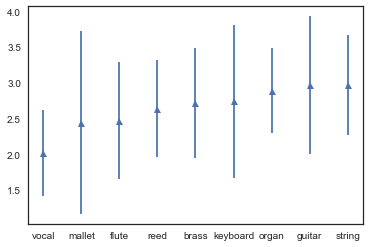

In [19]:
sns.set(font_scale = 1)
sns.set_style("white")
plt.errorbar(a.index, a["entropy","mean"], a["entropy","std"], linestyle='None', marker='^')

In [20]:
a = pd.DataFrame(instruments_diapason.groupby(["instrument_family_str","main_harmony"]).size())

In [21]:
b = pd.DataFrame(instruments_diapason.groupby(["instrument_family_str","second_main_harmony"]).size())

In [22]:
#main and second main harmony statistics
pd.concat([a,b],axis=1)

0      0
brass  0     4.0   10.0
       1     5.0   10.0
       2     NaN    2.0
       3     NaN    3.0
       4    23.0  143.0
       5    19.0   10.0
       6     4.0    5.0
       7   188.0   40.0
       8     3.0    NaN
       9     4.0   22.0
       10    NaN    1.0
       11    NaN    4.0
flute  0     NaN    1.0
       1     9.0   14.0
       2     2.0    5.0
       3     4.0    4.0
       4     NaN   73.0
       5     NaN    7.0
       6     4.0    NaN
       7   106.0   25.0
       8     6.0    3.0
       9     NaN    2.0
       10    6.0    2.0
       11    1.0    2.0
guitar 0     4.0   13.0
       1    18.0    1.0
       2     NaN    2.0
       3    13.0    3.0
       4    14.0   37.0
       5    10.0    4.0
...          ...    ...
reed   0     NaN   15.0
       1     2.0    2.0
       2     4.0    NaN
       3     3.0   17.0
       4     4.0   78.0
       5    65.0   14.0
       6     8.0   26.0
       7   157.0   46.0
       8     5.0    5.0
       9     3.0   33.0
       10    1.0    8.0
       11    NaN    8.0
string 0     NaN    1.0
       1    10.0    NaN
       2     8.0   13.0
       3    19.0    7.0
       4    44.0  173.0
       5    20.0   13.0
       6    10.0    9.0
       7   214.0   64.0
       8     4.0   19.0
       9    16.0   21.0
       10    3.0   22.0
       11    2.0    8.0
vocal  4    23.0   18.0
       5     NaN    5.0
       6     NaN    2.0
       7    87.0   40.0
       8     NaN   20.0
       10    NaN   25.0

[90 rows x 2 columns]

## Formatting for the LSTM algorithm

In [23]:
#duplicating contextual variables columns to create buffers between samples
test_sample_diapason2=test_sample_diapason
for i in range(1,30):
    test_sample_diapason2["entropy_"+str(i)] = test_sample_diapason2["entropy"]
    test_sample_diapason2["second_main_harmony_"+str(i)] = test_sample_diapason2["second_main_harmony"]
    test_sample_diapason2["main_harmony_"+str(i)] = test_sample_diapason2["main_harmony"]

In [24]:
#putting duplicates in front of samples
cols2 = list(test_sample_diapason2.columns)
new_cols2 = cols2[87:]+cols2[:87]
test_sample_diapason2=test_sample_diapason2[new_cols2]
test_sample_diapason2.head(5)

,entropy_1,second_main_harmony_1,main_harmony_1,entropy_2,second_main_harmony_2,main_harmony_2,entropy_3,second_main_harmony_3,main_harmony_3,entropy_4,...,54,66,78,8,20,32,44,56,68,80
reed_acoustic_024-069-025,2.954621,11,7,2.954621,11,7,2.954621,11,7,2.954621,...,0.007414,0.038331,0.041789,0.038351,0.002455,0.003137,0.790524,0.349385,0.125873,0.026209
mallet_acoustic_048-069-075,3.293562,11,4,3.293562,11,4,3.293562,11,4,3.293562,...,0.002185,0.000354,0.000013,0.004899,0.003015,0.007166,0.074028,0.002131,0.000290,0.000019
keyboard_acoustic_017-069-075,1.511891,4,10,1.511891,4,10,1.511891,4,10,1.511891,...,0.003224,0.001187,0.000941,0.000066,0.000108,0.000659,0.500956,0.004544,0.001462,0.001198
reed_acoustic_041-069-050,2.628567,7,7,2.628567,7,7,2.628567,7,7,2.628567,...,0.006189,0.020854,0.011521,0.010269,0.002569,0.002828,1.154987,0.255929,0.144207,0.009488
reed_acoustic_056-069-050,2.425185,5,7,2.425185,5,7,2.425185,5,7,2.425185,...,0.008613,0.026682,0.013781,0.016040,0.003310,0.003084,1.612050,0.271453,0.052350,0.007017


In [25]:
#defining training set and test set size
n_train = 800
n_test = 99

In [26]:
#defining test set, concatenating all samples of training set
test_set = test_sample_diapason2.iloc[n_train:n_train+n_test+1,]
test_sample_diapason2_list =  test_sample_diapason2.iloc[:n_train,].values.tolist()
test_sample_diapason2_list = [item for sublist in test_sample_diapason2_list for item in sublist]

In [27]:
#defining mean prediction for comparison
mean_prediction = test_sample_diapason2.iloc[:n_train,].mean(axis = 0)

In [28]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
test_sample_diapason2_list = np.asarray(test_sample_diapason2_list).reshape(-1, 1)
training_set_scaled = sc.fit_transform(test_sample_diapason2_list)

In [29]:
# Creating a data structure with 90 timesteps and 1 output
X_train = []
y_train = []
for i in range(90, (len(test_sample_diapason2_list)-1)):
    X_train.append(training_set_scaled[i-90:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [31]:
X_train.shape

(139109, 90, 1)

Building the LSTM model

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import model_from_json

C:\Users\Pigo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [33]:
# Creating the model
regressor = Sequential()

# Adding the first layer
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [86]:
# Adding the second layer
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

In [87]:
# Adding the third layer
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

In [88]:
# Adding the fourth layer
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

In [89]:
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting model to training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)



Instructions for updating:
Use tf.cast instead.
Epoch 1/100
139109/139109 [==============================] - 1433s 10ms/step - loss: 0.0166
Epoch 2/100
139109/139109 [==============================] - 1461s 11ms/step - loss: 0.0041
Epoch 3/100
139109/139109 [==============================] - 1460s 10ms/step - loss: 0.0029
Epoch 4/100
139109/139109 [==============================] - 1471s 11ms/step - loss: 0.0025
Epoch 5/100
139109/139109 [==============================] - 1461s 11ms/step - loss: 0.0021
Epoch 6/100
139109/139109 [==============================] - 1468s 11ms/step - loss: 0.0018
Epoch 7/100
139109/139109 [==============================] - 1460s 10ms/step - loss: 0.0014
Epoch 8/100
139109/139109 [==============================] - 1463s 11ms/step - loss: 0.0013
Epoch 9/100
139109/139109 [==============================] - 1462s 11ms/step - loss: 0.0013
Epoch 10/100
139109/139109 [==============================] - 1465s 11ms/step - loss: 0.0012
Epoch 11/100
139109/139109 [===

## Prediction

In [34]:
#Building an example input for prediction
X_test = test_set.iloc[0,:90]
X_test = np.asarray(X_test).reshape(-1, 1)
X_test = sc.transform(X_test)
y_test = test_set.iloc[0,90:]
y_test = np.asarray(y_test).reshape(-1, 1)
y_test = sc.transform(y_test)
X_test, y_test = np.array(X_test), np.array(y_test)

In [35]:
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))

In [36]:
X_test.shape

(1, 90, 1)

In [37]:
# saving model
model_as_json = regressor.to_json()
with open("model_800.json", "w") as json_file:
    json_file.write(model_as_json)
regressor.save_weights("model_800.h5")
print("Model saved")

Model saved


In [40]:
# loading model back to check if it was saved correctly
json_file = open('model_800.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
regressor = model_from_json(loaded_model_json)
regressor.load_weights("model_800.h5")
print("Model loaded")

Model loaded


In [41]:
#Generating a new sample using the contextual variables input from X_test
X_test2=X_test
for i in range(len(y_test)):
    X_test2=np.append(X_test2[0,1:,0],regressor.predict(X_test2))
    X_test2 = np.asarray(X_test2).reshape(-1, 1)
    X_test2 = np.reshape(X_test2, (1, X_test2.shape[0], 1))

In [42]:
X_test2=np.asarray(X_test2[0,:,0]).reshape(-1, 1)
X_test2=sc.inverse_transform(X_test2)
X_test2[6:,0].shape

(84,)

In [44]:
#Taking real sample for comparison with generated sample
y_test=sc.inverse_transform(y_test)
y_test[:,0].shape

(84,)

In [45]:
y_test_bis = instruments_diapason.iloc[n_train]["cqt_mean"]

In [46]:
#putting notes back in the right order
notes_order_inverse = [2,8,3,9,1,4,10,5,11,0,7,6]
cols_inverse=[]
for i in range(0,7) :
    for j in notes_order_inverse :
            cols_inverse.append(j*7+i)

In [47]:
rebuilt_sample = np.asarray([i[0] for i in np.asarray(pd.DataFrame(X_test2[6:,0]).iloc[cols_inverse])])

In [48]:
#playing full real sample
ipd.Audio(instruments_diapason.iloc[n_train]["sample"], rate=16000)

In [49]:
#playing real sample reconstructed from mean CQT
new_C = np.array(1001*[[complex(i) for i in y_test_bis]])
new_C = new_C.transpose()
new_sample = librosa.icqt(new_C,hop_length=64)
ipd.Audio(new_sample, rate=16000)

C:\Users\Pigo\Anaconda3\lib\site-packages\librosa\core\constantq.py:615: UserWarning: librosa.icqt is unstable, and subject to change in future versions. Please use with caution.
  warnings.warn('librosa.icqt is unstable, and subject to change in future versions. '
C:\Users\Pigo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Pigo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Use

In [50]:
#playing sample built by LSTM algorithm
new_C2 = np.array(1001*[[complex(i) for i in rebuilt_sample]])
new_C2 = new_C2.transpose()
new_sample2 = librosa.icqt(new_C2,hop_length=64)
ipd.Audio(new_sample2, rate=16000)

C:\Users\Pigo\Anaconda3\lib\site-packages\librosa\core\constantq.py:615: UserWarning: librosa.icqt is unstable, and subject to change in future versions. Please use with caution.
  warnings.warn('librosa.icqt is unstable, and subject to change in future versions. '
C:\Users\Pigo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Pigo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Use

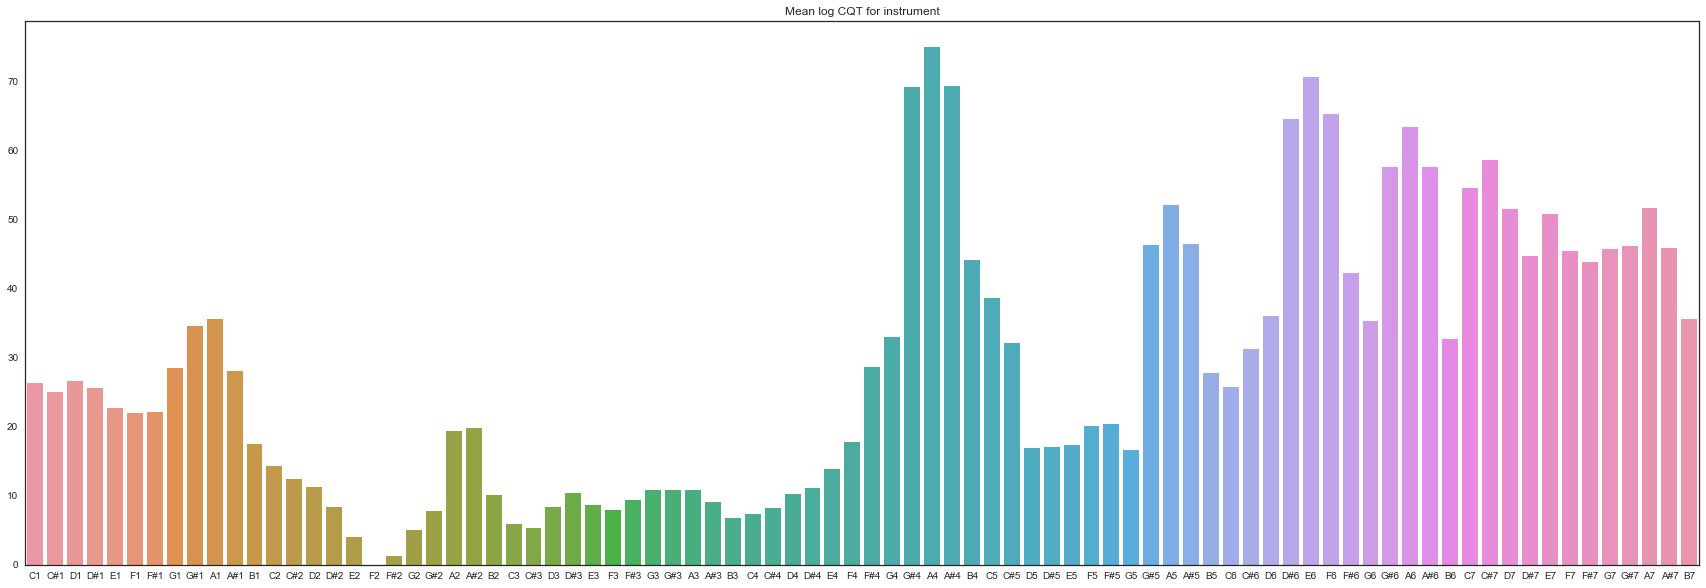

In [51]:
#displaying mean CQT of real sample
octaves = []
for i in range(1,8):
    octaves= octaves+['C'+str(i),'C#'+str(i),'D'+str(i),'D#'+str(i),'E'+str(i),'F'+str(i),'F#'+str(i),'G'+str(i),'G#'+str(i),'A'+str(i),'A#'+str(i),'B'+str(i)]
logC_mean = librosa.amplitude_to_db(y_test_bis,ref=np.min)

plt.figure(figsize=(30,10))
plt.title("Mean log CQT for instrument")
sns.barplot(y=logC_mean, x=octaves)

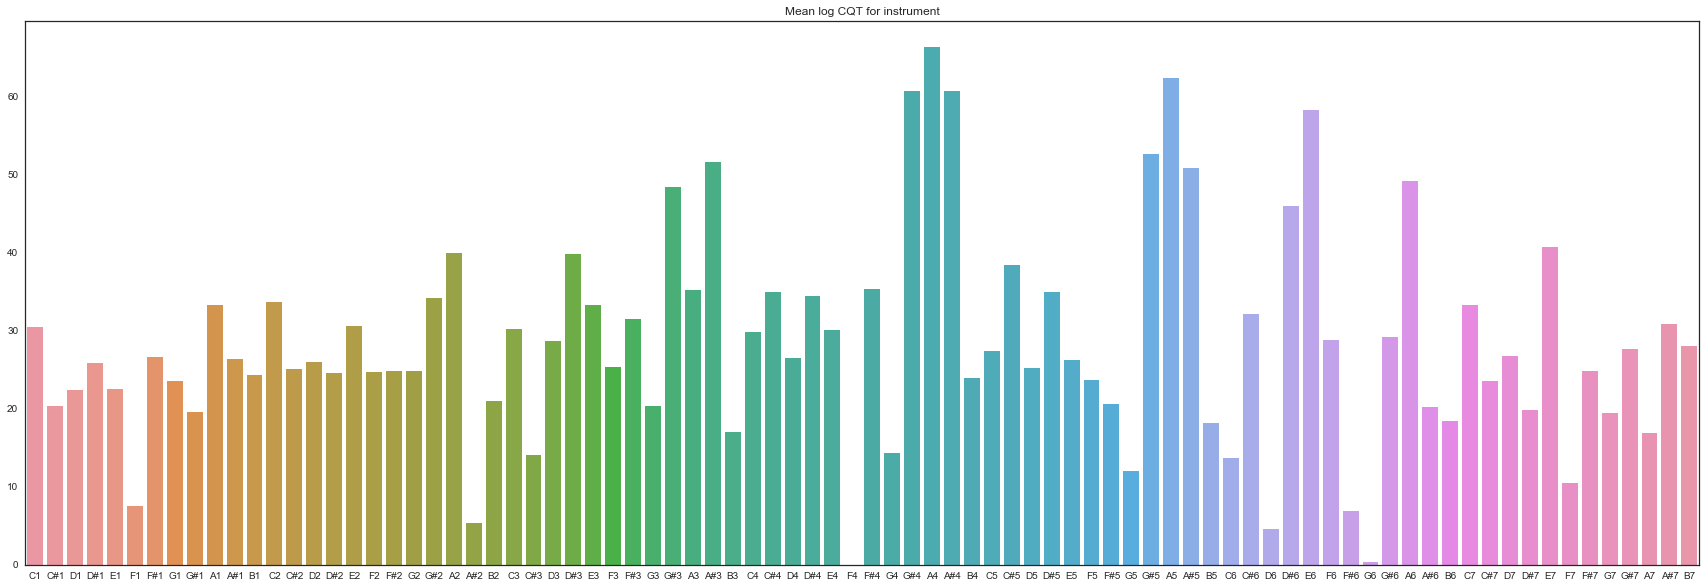

In [52]:
#displaying mean CQT for generated sample
octaves = []
for i in range(1,8):
    octaves= octaves+['C'+str(i),'C#'+str(i),'D'+str(i),'D#'+str(i),'E'+str(i),'F'+str(i),'F#'+str(i),'G'+str(i),'G#'+str(i),'A'+str(i),'A#'+str(i),'B'+str(i)]
logC_mean = librosa.amplitude_to_db( rebuilt_sample,ref=np.min)

plt.figure(figsize=(30,10))
plt.title("Mean log CQT for instrument")
sns.barplot(y=logC_mean, x=octaves)